In [99]:
"""
Created on Fri Mar 11 10:45:01 2022

@author: leotc
"""

from numpy import *
from math import isclose
import os 
import statistics
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import emcee

In [100]:
# sorry, was lazy with directory
totalpoints = open("C:/Users/leotc/Documents/Uni/PHYS3080/Distance_Ladder/Data/Camera Images/calibrated star data.txt", "r")      
pointdata = totalpoints.readlines()[1:]

In [101]:
distance = []
periods = []
luminosity = []

for i in pointdata:
    
    i = i.split()
    period = i[-3]
    green_flux = i[4]
    dist = i[-4]
    
    if float(period) != 0: 
        periods.append(float(period))
        abs_mag = np.log10(float(green_flux)) + 2*np.log10(float(dist))
        luminosity.append(abs_mag)

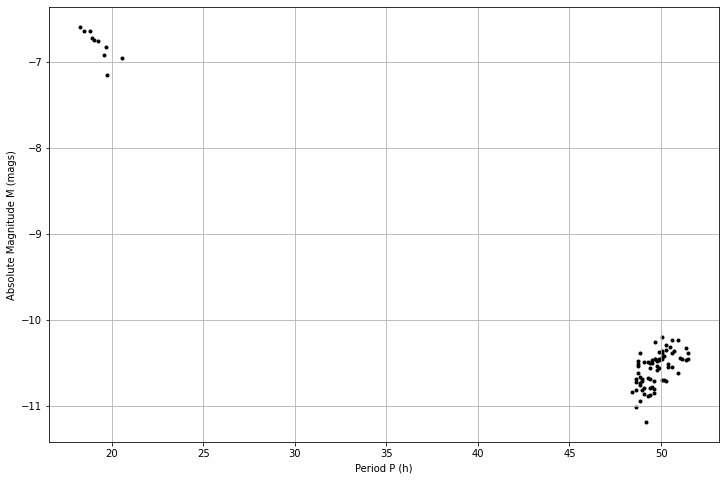

In [130]:
plt.scatter(periods, luminosity, marker='.', c='k')
plt.xlabel('Period P (h)')
plt.ylabel('Absolute Magnitude M (mags)')
plt.grid()

- Distance uncertainty: <br />
# $ \Delta D = D^{2}*\Delta\theta $ <br />
- Absolute Magnitude uncertainty:
# $ \Delta Abs Mag = \sqrt{(\frac{\Delta F_{green}}{2.3})^{2}+(\frac{2D\Delta\theta}{2.3})^{2}} $ <br />
- Note: <br />
# $ \Delta\theta = 0.001 arcsec $ 
# $ \Delta F_{green} = 0.015 W/m^{2}/nm $ 





In [1]:
def period_lum_uncert(star_periods, star_mag, xerr, yerr, runs = 1000):
    """
    Function for calcuationg the uncertianty in period luminosity relation for stars using monte carlo method
    
    Inputs: star_periods <list>: list of star periods
            star_mag <list>: list of absolute star magnitudes
            xerr <list>: list of uncertainties in period values
            yerr <list>: list of uncertainties in abs magnitude values    
            runs <int>: number of monte carlo iterations to perform, default = 1000
    
    Returns: <tuple>: uncertainty in relation gradient and y-intercept (standard deviation of both)
    """
    np.random.seed(1001)
    
    i=0
    var_m = []
    var_c = []
    
    while i<runs:
        
        # add random error to each flux term based on uniform distribution of uncertainties
        star_mag_jitter = star_mag + ([a*b for a,b in zip(star_mag, yerr*np.random.uniform(low=-1, high=1, size=len(yerr)))])
        star_periods_jitter = star_periods + ([a*b for a,b in zip(star_periods, xerr*np.random.uniform(low=-1, high=1, size=len(xerr)))])

        poly_fit = np.polyfit(star_periods_jitter, star_mag_jitter, 1)
        var_m.append(poly_fit[0])
        var_c.append(poly_fit[1])
        i+=1
    
    # return standard deviation of simulation as uncertianty
    return (np.std(var_m), np.std(var_c)) 

# Long Periods

In [85]:
distance = []
long_periods = []
long_luminosity = []
long_yerr = []
long_xerr = []

for i in pointdata:
    
    i = i.split()
    period = float(i[-3])
    green_flux = float(i[4])
    dist = float(i[-4])
    x_uncert = float(i[-2])
    
    if float(period) > 35:
        long_xerr.append(x_uncert)
        long_periods.append(period)
        abs_mag = np.log10(green_flux) + 2*np.log10(dist)
        long_yerr.append(((0.015/2.3)**2+((2*dist*0.001)**2))**(1/2)) 
        long_luminosity.append(abs_mag)

Text(50.2, -11.3, 'M = 0.148±0.004*P - 17.9±0.2')

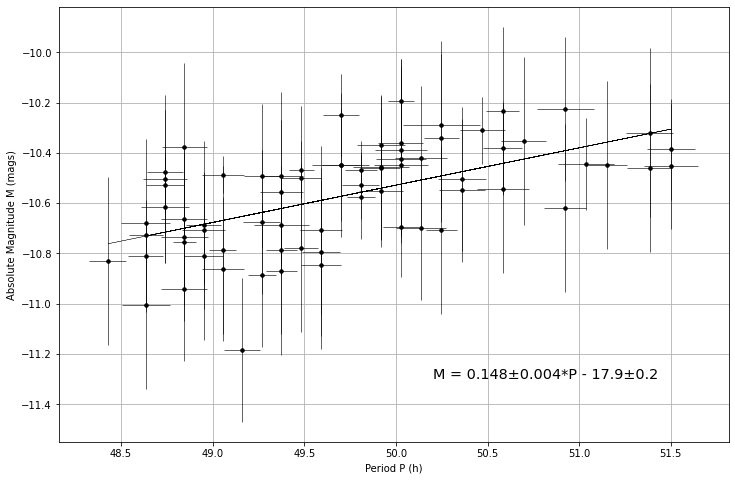

In [141]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.errorbar(long_periods, long_luminosity, yerr=long_yerr, xerr=long_xerr, fmt='.k', markersize='7', elinewidth=0.6)
ax1.plot(long_periods,long_poly(long_periods),"k",  linewidth=0.3)
ax1.grid()
plt.rcParams["figure.figsize"] = (12, 8)
plt.xlabel('Period P (h)')
plt.ylabel('Absolute Magnitude M (mags)')
plt.text(50.2,-11.3,"M = 0.148\u00B10.004*P - 17.9\u00B10.2", fontsize='x-large')

In [87]:
period_lum_uncert(long_periods, long_luminosity, long_xerr, long_yerr)

(0.004337989465431641, 0.21555434533072085)

In [88]:
long_fit = np.polyfit(long_periods, long_luminosity, 1)
long_poly = np.poly1d(long_fit)

In [89]:
long_poly

poly1d([  0.14836345, -17.94644976])

- For stars with long periods (~50hrs), the relation is given as: <br />
## $ Abs Mag = 0.148\pm0.004*P - 17.9\pm0.2 $ <br />
- explicitly:
## $ distance_{long}(pc) = \sqrt{\frac{10^{0.148\pm0.004*P (hours) - 17.9\pm0.2}}{green flux (W/m^{2}/nm)}} $

# Short Periods

In [90]:
distance = []
short_periods = []
short_luminosity = []
short_yerr = []
short_xerr = []

for i in pointdata:
    
    i = i.split()
    period = float(i[-3])
    green_flux = float(i[4])
    dist = float(i[-4])
    x_uncert = float(i[-2])
    star_name = str(i[0])
    
    if star_name == 'P00789': # NOTE, this star had no clear period in it's data, was thus excluded 
        continue        
        
    if period < 35 and period != 0:
        short_xerr.append(x_uncert)
        short_periods.append(period)
        abs_mag = np.log10(green_flux) + 2*np.log10(dist)
        short_yerr.append(((0.015/2.3)**2+((2*dist*0.001)**2))**(1/2)) 
        short_luminosity.append(abs_mag)

In [91]:
period_lum_uncert(short_periods, short_luminosity, short_xerr, short_yerr)

(0.020336231063719516, 0.3881331177998594)

In [92]:
short_fit = np.polyfit(short_periods, short_luminosity, 1)
short_poly = np.poly1d(short_fit)

In [93]:
short_poly

poly1d([-0.27911615, -1.44986071])

- For stars with short periods (~50hrs), the relation is given as: <br />
## $ Log(Flux) = -0.28\pm0.02*P - 1.4\pm0.4 $ <br />
- explicitly:
## $ distance_{short}(pc) = \sqrt{\frac{10^{-0.28\pm0.02*P (hours) - 1.4\pm0.4}}{green flux (W/m^{2}/nm)}} $

Text(18.35, -7.3, 'M = -0.28±0.02*P - 1.4±0.4')

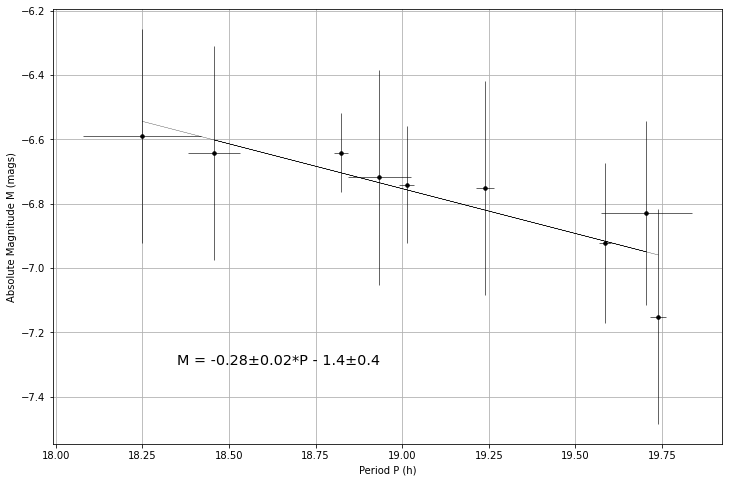

In [144]:
fig = plt.figure()
ax2 = fig.add_subplot(111)

ax2.errorbar(short_periods, short_luminosity, yerr=short_yerr, xerr=short_xerr, fmt='.k', markersize='7', elinewidth=0.6)
ax2.plot(short_periods,short_poly(short_periods),"k", linewidth=0.3)
ax2.grid()
plt.rcParams["figure.figsize"] = (12, 8)
plt.xlabel('Period P (h)')
plt.ylabel('Absolute Magnitude M (mags)')
plt.text(18.35,-7.3,"M = -0.28\u00B10.02*P - 1.4\u00B10.4", fontsize='x-large')